# Training Data Preparation

This notebook is used to examine data and remove data before any modeling steps (data partitioning, training, etc.)

- Load all features (from genomes) and phenotypic data
- Selection of features (removes features)
- QC of genomes (removes genomes)
- QC of phenotypic data (removes genomes)
- Save datasets

In [8]:
# edit these files
FEATURES_DIRECTORY = '../data/features/'
BACDIVE_DATA_FILE = '../data/training_data/bacdive_data.json'
OUTPUT_TRAINING_DATA_TSV = '../data/training_data/training_data_20241213.tsv' #training_data_20231203.tsv'
GTDB_TAXONOMY_TABLE = '../data/references/all_taxonomy_r214.tsv'
HOLDOUT_DIRECTORY = '../data/holdouts/'

In [38]:
import json
from glob import glob
import sys 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../")
from genome_spot.model_training.download_training_data import ComputeBacDiveTraits, load_targets_to_dataframe
from genome_spot.model_training.taxonomy import TaxonomyGTDB
from genome_spot.model_training.partition import PartitionTaxa
from genome_spot.model_training.balance import BalanceTaxa
from genome_spot.helpers import rename_condition_to_variable, load_train_and_test_sets
plt.style.use('project.mplstyle')

## Load data



### Features (genomic data)

In [11]:
# json.loads(open('data/features/GCA_0043637251.features.json').read()).keys()
# filename = 'data/features/GCA_0043637251.features.json'

def load_genome(filename):
    flatten_by_localization = False
    # FIX: misnamed genome
    #genome = filename.split('/')[-1].split('.')[0][:-1]
    genome = filename.split('/')[-1].split('.')[0]

    sers = []
    json_df = pd.read_json(filename)
    for col in json_df.columns:
        ser = json_df.loc[:, col]
        ser.name = genome
        index_tuples = list(zip([col] * len(ser), ser.index.tolist()))
        index = pd.MultiIndex.from_tuples(index_tuples, names=["localization", "variable"])
        ser.index = index
        sers.append(ser)
        
    df_genome = pd.concat(sers, axis=0)
    return df_genome

def load_features_to_dataframe(features_dir):
    sers = []
    for filename in glob(features_dir + '*.features.json'):
        ser_genome = load_genome(filename)
        sers.append(ser_genome)
    df_features = pd.concat(sers, axis=1).T

    # Missing data should be 0
    df_features = df_features.fillna(0.)
    return df_features

# df_features = load_features_to_dataframe(features_dir = FEATURES_DIRECTORY) 
# renamed_cols = ['_'.join(ser) for ser in df_features]
# df_features.columns = df_features.columns.droplevel()
# df_features.columns = renamed_cols
# df_features.to_csv('temp.features.csv')
df_features = pd.read_csv('temp.features.csv', index_col=0)
init_cols = df_features.columns
df_features

,all_nt_length,all_pur_pyr_transition_freq,all_nt_C,all_nt_A,all_total_proteins,all_total_protein_length,all_pis_acidic,all_pis_neutral,all_pis_basic,all_pis_3_4,...,diff_extra_intra_aa_HM,diff_extra_intra_aa_YI,diff_extra_intra_aa_QC,diff_extra_intra_aa_YC,diff_extra_intra_aa_CM,diff_extra_intra_aa_NM,diff_extra_intra_aa_CH,diff_extra_intra_aa_MC,diff_extra_intra_aa_CN,diff_extra_intra_protein_coding_density
GCA_003351045,3028597.0,0.536884,0.716499,0.283501,3119.0,914322.0,0.419045,0.264828,0.316127,0.0,...,-0.000066,0.000185,-0.000088,-0.000067,-0.000074,0.000017,-0.000046,-0.000134,0.000002,0.0
GCA_900635285,2835267.0,0.501540,0.328374,0.671626,2617.0,785156.0,0.364922,0.304165,0.330913,0.0,...,-0.000513,-0.001401,-0.000086,-0.000318,0.000000,-0.000673,0.000000,0.000000,0.000000,0.0
GCA_900450125,5062071.0,0.518257,0.505235,0.494765,4684.0,1446017.0,0.292699,0.422289,0.285013,0.0,...,-0.000213,-0.000332,-0.000214,-0.000196,-0.000122,0.000153,-0.000209,-0.000148,-0.000299,0.0
GCA_003258705,5379841.0,0.449242,0.371974,0.628026,4331.0,1597801.0,0.382360,0.366197,0.251443,0.0,...,0.000067,-0.000471,-0.000146,-0.000258,-0.000124,0.000278,-0.000187,-0.000062,-0.000145,0.0
GCA_008033445,2665295.0,0.555118,0.716844,0.283156,2473.0,802747.0,0.156490,0.475536,0.367974,0.0,...,-0.000006,0.000033,-0.000067,-0.000032,-0.000071,0.000043,-0.000030,-0.000136,-0.000079,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_002895005,3049617.0,0.474641,0.354251,0.645749,2739.0,941086.0,0.358525,0.361811,0.279664,0.0,...,-0.000087,-0.000611,0.000100,-0.000107,0.000120,-0.000862,0.000197,-0.000105,-0.000255,0.0
GCA_000300335,4466307.0,0.517709,0.655115,0.344885,4197.0,1306143.0,0.353109,0.402907,0.243984,0.0,...,-0.000051,0.000063,0.000057,0.000082,0.000068,0.000147,-0.000017,-0.000080,0.000039,0.0
GCA_004339805,4632377.0,0.490578,0.461756,0.538244,4501.0,1365617.0,0.265497,0.474117,0.260387,0.0,...,0.000081,0.000106,-0.000333,-0.000369,-0.000144,0.000173,-0.000310,0.000000,-0.000389,0.0
GCA_000953375,1016762.0,0.445851,0.236659,0.763341,744.0,216589.0,0.122312,0.279570,0.598118,0.0,...,0.000000,-0.003523,0.000000,0.000000,0.000000,-0.000505,0.000000,0.000000,-0.000154,0.0


In [12]:
len(df_features)

15627

### Targets (phenotypic data)

In [19]:
df_targets = load_targets_to_dataframe(bacdive_download_file=BACDIVE_DATA_FILE)
df_targets.head(2)

,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,...,use_oxygen,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant
GCA_000425045.1,GCA_000425045.1,1120921,99,Acidaminococcus intestini,None,None,None,None,None,None,...,True,None,1,None,None,None,1,None,None,None
GCA_000025305.1,GCA_000025305.1,591001,98,Acidaminococcus fermentans,None,None,None,None,None,None,...,True,None,1,None,None,None,None,None,None,None


In [20]:
quantitative_vars = sorted(['ph_optimum','ph_optimum_min','ph_optimum_max', 'temperature_optimum','salinity_optimum',  'salinity_midpoint', 'salinity_min', 'salinity_max', 'ph_min', 'ph_max', 'temperature_min', 'temperature_max',])
df_targets['ncbi_accession'] = [acc.split('.')[0] for acc in df_targets['ncbi_accession']]
df_targets = df_targets[~df_targets['ncbi_accession'].isnull()].set_index('ncbi_accession')
df_targets.loc[:, quantitative_vars] = df_targets.loc[:, quantitative_vars].astype(float)
df_targets = df_targets.rename(columns={'species' : 'ncbi_species'})

taxonomy = TaxonomyGTDB()
for taxlevel, index in taxonomy.indices.items():
    df_targets[taxlevel] = df_targets.index.map({k : v[index] for k, v in taxonomy.taxonomy_dict.items()})


df_targets.head(2)

,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,facultative aerobe,aerotolerant,microaerotolerant,domain,phylum,class,order,family,genus,species
ncbi_accession,,,,,,,,,,,,,,,,,,,,,
GCA_000425045,1120921,99,Acidaminococcus intestini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,Bacteria,Bacillota_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,Acidaminococcus intestini
GCA_000025305,591001,98,Acidaminococcus fermentans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,Bacteria,Bacillota_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,Acidaminococcus fermentans


In [21]:
df_targets[(df_targets['use_salinity'] == True) & (df_targets['salinity_optimum'] == 0)].shape

(205, 36)

In [22]:
# screen salinity
# 'GCA_003751385', 'GCA_023078355', 'GCA_000956175', 'GCA_000875775'
df_targets[ (df_targets['salinity_optimum'] > 14)][['species', 'family', 'class']].sort_values('family')[:50]

,species,family,class
ncbi_accession,,,
GCA_001311865,Piscibacillus salipiscarius,Alkalibacillaceae,Bacilli
GCA_003751385,Desulfosoma caldarium,DSM-9756,Syntrophobacteria
GCA_000430745,Fictibacillus_A gelatini,Fictibacillaceae,Bacilli
GCA_900156425,Haladaptatus litoreus,Haladaptataceae,Halobacteria
GCA_008831545,Halorussus halophilus,Haladaptataceae,Halobacteria
GCA_000710615,Haladaptatus cibarius,Haladaptataceae,Halobacteria
GCA_000379085,Halomicrobium katesii,Haloarculaceae,Halobacteria
GCA_014647415,Haloarcula sebkhae,Haloarculaceae,Halobacteria
GCA_019599515,Halomicroarcula pellucida,Haloarculaceae,Halobacteria


In [23]:
too_low = df_targets[ (df_targets['salinity_optimum'] < 3.7) & (df_targets['class'].isin(['Halobacteria']))]
print(too_low.index)
too_low

Index(['GCA_001971705', 'GCA_013415885', 'GCA_013415905', 'GCA_017352095',
       'GCA_020105915'],
      dtype='object', name='ncbi_accession')


,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,facultative aerobe,aerotolerant,microaerotolerant,domain,phylum,class,order,family,genus,species
ncbi_accession,,,,,,,,,,,,,,,,,,,,,
GCA_001971705,588898,133550,Haloterrigena daqingensis,10.0,10.0,10.0,35.0,2.25,3.6,1.7,...,None,None,None,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Natrialbaceae,Natronorubrum,Natronorubrum daqingense
GCA_013415885,869889,134076,Halosimplex rubrum,7.0,7.0,7.0,42.0,3.1,2.15,0.9,...,None,None,None,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloarculaceae,Halosimplex,Halosimplex rubrum
GCA_013415905,869886,134075,Halosimplex pelagicum,7.0,7.0,7.0,42.0,3.4,3.1,1.4,...,None,None,None,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloarculaceae,Halosimplex,Halosimplex pelagicum
GCA_017352095,370324,134202,Haloterrigena longa,7.25,7.0,7.5,43.0,2.9,2.9,0.0,...,None,None,None,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Natrialbaceae,Natrinema,Natrinema ejinorense
GCA_020105915,1230457,134201,Haloterrigena limicola,7.25,7.0,7.5,47.5,0.29,2.03,0.0,...,None,None,None,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Natrialbaceae,Natrinema,Natrinema ejinorense


In [24]:
labels =  {
            "obligate aerobe",
            "aerobe",
            "facultative anaerobe",
            "facultative aerobe",
            "microaerophile",
            "aerotolerant",
    "obligate anaerobe", "anaerobe"}

list(labels)

['aerobe',
 'anaerobe',
 'microaerophile',
 'facultative aerobe',
 'aerotolerant',
 'obligate aerobe',
 'facultative anaerobe',
 'obligate anaerobe']

In [25]:
df_targets.loc['GCA_000174915']

ncbi_taxid                          306
strain_id                         24400
ncbi_species            Pseudomonas sp.
ph_optimum                          NaN
ph_optimum_min                      NaN
ph_optimum_max                      NaN
temperature_optimum                 NaN
salinity_optimum                    NaN
salinity_midpoint                   NaN
salinity_min                        NaN
salinity_max                        NaN
ph_min                              NaN
ph_max                              NaN
temperature_min                    28.0
temperature_max                    28.0
oxygen                             None
use_ph                            False
use_temperature                   False
use_salinity                      False
use_oxygen                        False
aerobe                             None
anaerobe                           None
microaerophile                     None
facultative anaerobe               None
obligate aerobe                    None


## QC of genomes

In [26]:
MIN_PROTEIN_CODING_DENSITY = 0.60
MAX_PROTEIN_CODING_DENSITY = 1.

below_coding_density_filter = df_features[df_features['all_protein_coding_density'] < MIN_PROTEIN_CODING_DENSITY].index.tolist()
above_coding_density_filter = df_features[df_features['all_protein_coding_density'] > MAX_PROTEIN_CODING_DENSITY].index.tolist()
genomes_to_drop = ['GCA_000174915', # 6 total proteins?
                'GCA_905142475', 'GCA_905220785', # proteins double counted
                   
] + below_coding_density_filter + above_coding_density_filter


Text(0.5, 1.0, 'Coding Density Filter for Genome Quality')

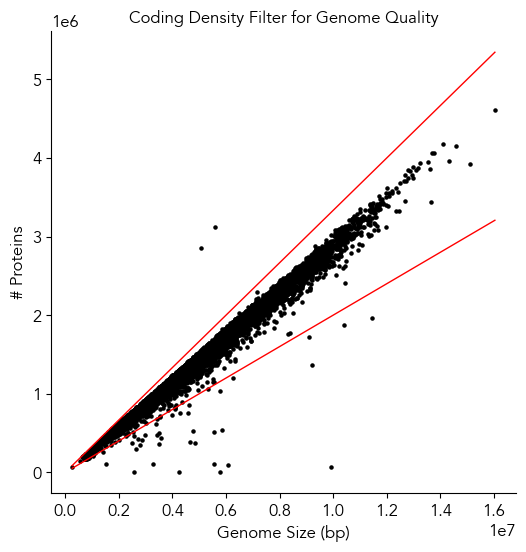

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
X = df_features['all_nt_length'].values
Y = df_features['all_total_protein_length'].values
ax.scatter(X, Y, s= 5)
ax.plot([X.min(), X.max(), ], [0.6*(1/3)*X.min(), 0.6*(1/3)*X.max()], color='red')
ax.plot([X.min(), X.max(), ], [1.0*(1/3)*X.min(), 1.0*(1/3)*X.max()], color='red')
ax.set_xlabel('Genome Size (bp)')
ax.set_ylabel('# Proteins')
ax.set_title('Coding Density Filter for Genome Quality')

In [28]:
print(df_features.shape)
df_features = df_features.drop(genomes_to_drop)
print(df_features.shape)

(15627, 2230)
(15585, 2230)


## QC of phenotypic data

We want optima and ranges that were well-sampled

In [33]:
targets = ['oxygen', 'ph_optimum', 'salinity_optimum', 'temperature_optimum']
max_fraction = 0.01
for target in targets:
    Y = df_targets[target].dropna()
    value_frequency = (Y.value_counts() / len(Y))
    most_frequent_values = value_frequency[value_frequency > max_fraction].index
    print(target, value_frequency.head(1))
    print(sorted(most_frequent_values))

oxygen oxygen
1    0.765682
Name: count, dtype: float64
[0, 1]
ph_optimum ph_optimum
7.0    0.342495
Name: count, dtype: float64
[6.0, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.5, 9.0]
salinity_optimum salinity_optimum
2.0    0.109407
Name: count, dtype: float64
[0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.5, 10.0]
temperature_optimum temperature_optimum
28.0    0.198956
Name: count, dtype: float64
[20.0, 25.0, 26.0, 26.5, 27.5, 28.0, 29.0, 30.0, 31.0, 32.5, 33.5, 35.0, 36.0, 37.0, 40.0]


In [39]:
indices_to_remove = []


taxonomy = TaxonomyGTDB()

rng = np.random.default_rng(0)

def downsample_distribution_cap(Y, bins, max_fraction_per_bin=0.05):
    if bins is None:
        bins = 50
    
    hist, bins = np.histogram(Y, bins=bins)
    if max_fraction_per_bin is None:
        max_fraction_per_bin = len(bins)**-(1/1)
    max_per_bin = int(len(Y) * max_fraction_per_bin)
    
    indices = []
    y_indices = np.array([i for i in range(len(Y))])
    for i, count in enumerate(hist):
        y_bin_indices = y_indices[(Y >= bins[i]) & (Y < bins[i+1])]
        y_sample = rng.choice(y_bin_indices, size=min([len(y_bin_indices), max_per_bin]), replace=False)
        indices.extend(list(y_sample))
        #print(count, y_sample)

    Y_revised = Y[indices]
    return Y_revised

def downsample_most_freq_values(Y, max_fraction = 0.03):

    value_frequency = (Y.value_counts() / len(Y))
    allowed_values = value_frequency[value_frequency < max_fraction].index
    Y_revised = Y[Y.isin(allowed_values)]
    return Y_revised



def downsample_by_balancing(Y, keep=0.5, taxonomy=taxonomy):

    genomes = Y.index.tolist()
    taxonomy = TaxonomyGTDB()
    balancer = BalanceTaxa(taxonomy=taxonomy)
    balanced_genomes = balancer.balance_dataset(
        genomes=genomes,
        proportion_to_keep=keep,
        diversity_rank="species"
    )

    Y_revised = Y.loc[list(balanced_genomes)]
    return Y_revised
    

In [40]:
df_targets.shape, df_features.shape

((16327, 36), (15585, 2230))

In [41]:
df_targets[target].dropna()

ncbi_accession
GCA_000295095     0.5
GCA_002237365     2.0
GCA_000374105     2.5
GCA_000024085     2.5
GCA_025532145     7.5
                 ... 
GCA_003837865     0.5
GCA_003072065     3.0
GCA_003350345    3.25
GCA_003999375    2.75
GCA_003096015     0.0
Name: salinity_optimum, Length: 2477, dtype: object

833 555 0.6662665066026411 0.22406136455389583
0.0
12.189999999999998


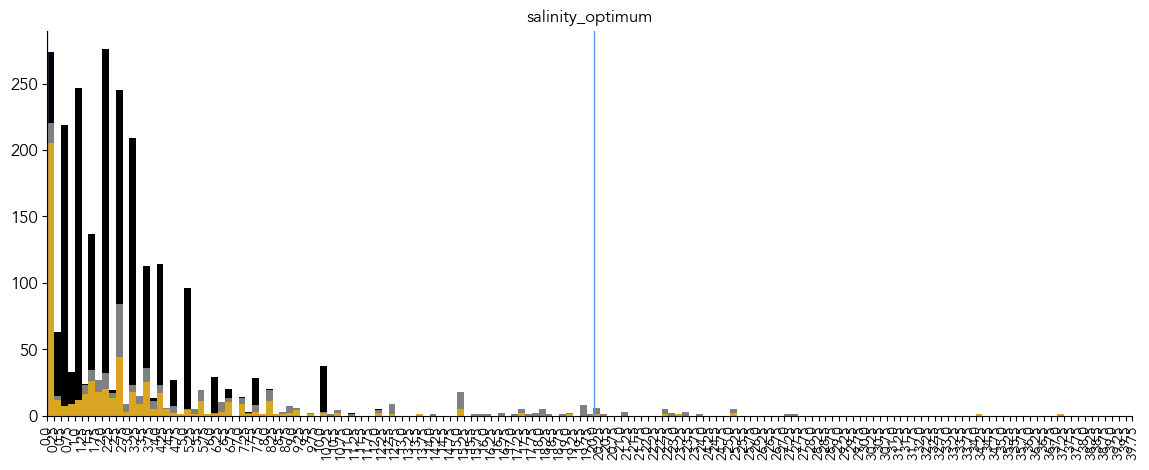

1071 714 0.6666666666666666 0.19240097008892482
4.4695
9.5


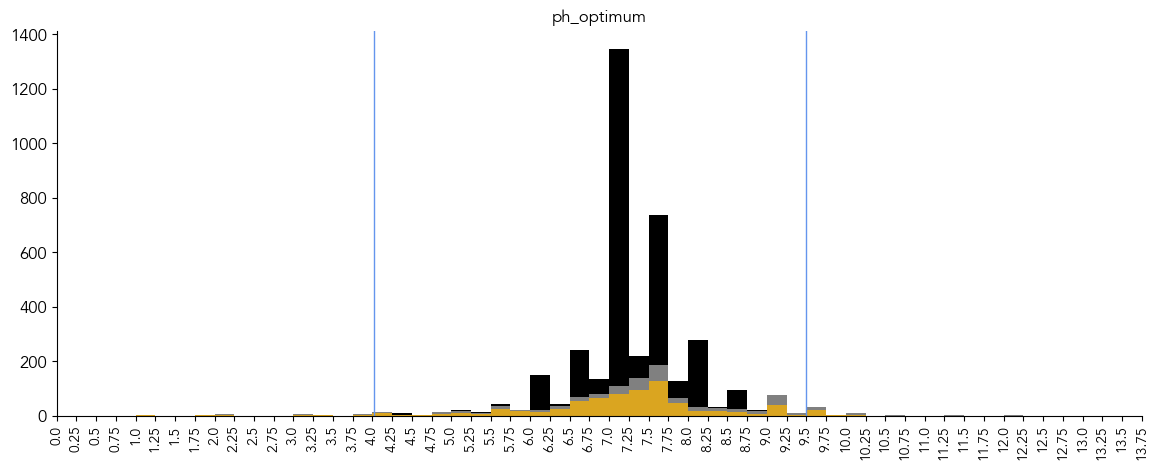

2527 1684 0.666402849228334 0.33808472194338485
15.489999999999995
65.0


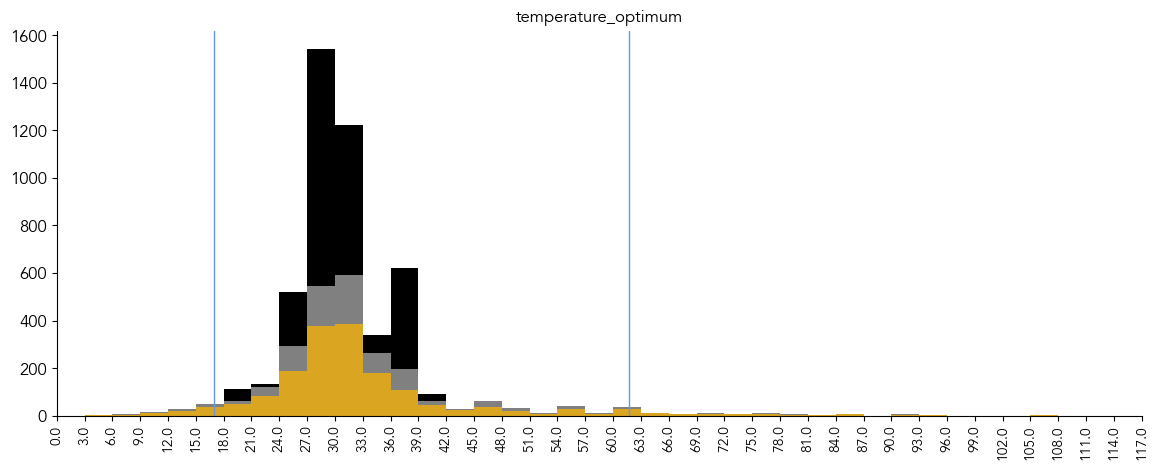

In [42]:

def ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step):
    bins = np.arange(bin_min, bin_max, bin_step)
    
    X1 = df_targets[target].dropna()
    X = df_targets.loc[df_targets[f"use_{target.replace('_optimum','')}"] == True, target].dropna()
    #X2 = downsample_distribution_cap(X, bins=50)
    X2 = downsample_by_balancing(X, keep=2/3)
    print(len(X), len(X2), len(X2)/len(X), len(X2)/len(X1))
    print(np.percentile(X2, 3))
    print(np.percentile(X2, 97))
    counts, bins, _ = ax.hist(X1, bins=bins, color='black')
    _, _, _ = ax.hist(X, bins=bins, color='gray')
    _, _, _ = ax.hist(X2, bins=bins, color='goldenrod')
    ax.set_xlim([min(bins), max(bins)])
    ax.set_xticks(bins)
    ax.set_xticklabels(bins, rotation=90, fontsize=10)
    ax.set_title(target)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yscale('log')
    for perc in [3, 97]:
        ax.axvline(np.percentile(X.values, perc), color='cornflowerblue')


target = 'salinity_optimum'
bin_min, bin_max, bin_step = 0,40,0.25
fig , ax = plt.subplots(figsize=(14,5))
ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step)
plt.show()

target = 'ph_optimum'
bin_min, bin_max, bin_step = 0, 14, 0.25
fig , ax = plt.subplots(figsize=(14,5))
ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step)
plt.show()


target = 'temperature_optimum'
bin_min, bin_max, bin_step = 0,120,3
fig , ax = plt.subplots(figsize=(14,5))
ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step)
plt.show()

## Save entire dataset (no test-train split)

In [43]:
# determined above
genomes_to_drop.extend([
    'GCA_000875775', # salinity decimal point error up
    'GCA_003751385', # salinity decimal point error up
    'GCA_023078355', # salinity decimal point error up
    'GCA_000956175', # salinity decimal point error up
    'GCA_001971705', # salinity decimal point error down
    'GCA_013415885', # salinity decimal point error down
    'GCA_013415905', # salinity decimal point error down
    'GCA_017352095', # salinity decimal point error down
    'GCA_020105915', # salinity decimal point error down
    ]
                      )


In [45]:
OVERWRITE_TRAINING_TSV = True
if OVERWRITE_TRAINING_TSV is True:
    df = df_targets.join(df_features, how='inner')
    
    print(df.shape)
    df = df.drop(set(genomes_to_drop).intersection(df.index.tolist()))
    print(df.shape)
    df.to_csv(OUTPUT_TRAINING_DATA_TSV, sep='\t')
    df.shape

(15585, 2266)
(15576, 2266)


# Check train/test splits

Must run `make_holdout_sets.py` beforehand

In [51]:
PATH_TO_HOLDOUTS = '../data/holdouts'

In [4]:
df = pd.read_csv(OUTPUT_TRAINING_DATA_TSV, index_col=0, sep='\t')


In [52]:
X_train

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, None,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, None, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, None,
       None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, None, 1,
       1, 1, 1, 1, None, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, None, None, 1,
       1, None, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, None, 1, 1, None, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, None, 1, 1, None, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, None, 1, 1, 0, 1, 0, 1, None, None, 1, 0, 1,
       None, None, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

oxygen
test     0.0
train    0.0
dtype: float64

temperature_optimum
test     0.153179
train    0.139535
dtype: float64

salinity_optimum
test     0.0
train    0.0
dtype: float64

ph_optimum
test     0.032680
train    0.011609
dtype: float64

138 571


TypeError: '<=' not supported between instances of 'int' and 'NoneType'

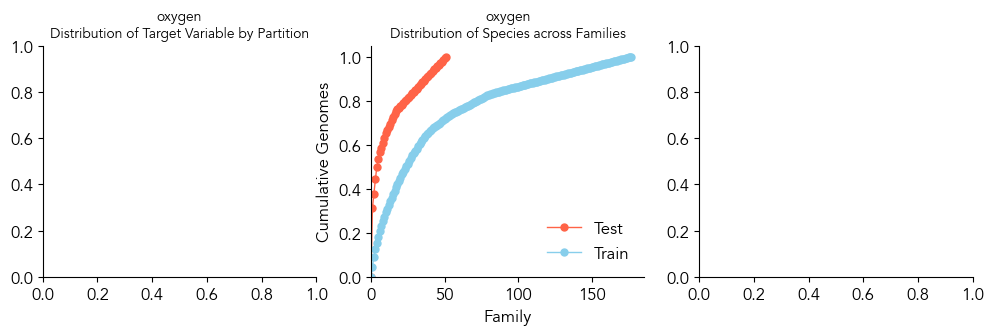

In [50]:
conditions = ['oxygen', 'temperature', 'salinity', 'ph']
taxonomy = TaxonomyGTDB()
from collections import Counter

for condition in conditions:
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    
    genome_to_taxlevel = taxonomy.taxonomy_dict_at_taxlevel(taxlevel='family')
    test_ser = pd.Series(Counter([genome_to_taxlevel.get(genome, None) for genome in test_set]))
    test_ser.name = 'test'
    train_ser = pd.Series(Counter([genome_to_taxlevel.get(genome, None) for genome in train_set]))
    train_ser.name = 'train'
    
    holdout_df = pd.concat([test_ser, train_ser], axis=1)
    holdout_df[(holdout_df['test'] > 0) & (holdout_df['train'] > 0)].sum()
    
    print(target)
    print(holdout_df[(holdout_df['test'] > 0) & (holdout_df['train'] > 0)].sum() / holdout_df.sum())
    print()
    
HOLDOUT_DIRECTORY = '../data/holdouts/'

test_color = 'tomato'
train_color = 'skyblue'
balancer = BalanceTaxa(taxonomy=taxonomy)

partitioner = PartitionTaxa(
        taxonomy=taxonomy,
        partition_rank='family',
        diversity_rank='genus',
    )

for target_type, bins in [
   ('oxygen', np.arange(0,2,0.5)),
                       ('ph',  np.arange(0,13,1)),
                       ('salinity', np.arange(0,37,1)),
                       ('temperature', np.arange(0,107,3)),
                 ]:

    
    if target_type == "oxygen":
        target = target_type
    else:
        target = target_type + "_optimum"
        
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    train_set = set(train_set)
    test_set = set(test_set)
    test_set_present = test_set.intersection(set(df[df[f'use_{target_type}'] == True].index.tolist()))
    train_set_present = train_set.intersection(set(df[df[f'use_{target_type}'] == True].index.tolist()))
    print(len(test_set_present), len(train_set_present))
    proportion_dict = balancer.assess_proportion(subset_genomes=test_set_present, reference_genomes=test_set_present.union(train_set_present), rank='phylum')
    test_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(test_set_present))
    train_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(train_set_present))


                     
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    
    ax = axes[1]
    X1 = [0] + list(pd.DataFrame.from_dict(test_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
    X2 = [0] + list(pd.DataFrame.from_dict(train_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
    ax.set_title(f"{target}\nDistribution of Species across Families", fontsize=10)
    ax.plot(range(len(X1)), np.cumsum(X1) / np.sum(X1), marker='.', color=test_color, label='Test')
    ax.plot(range(len(X2)), np.cumsum(X2) / np.sum(X2), marker='.', color=train_color, label='Train')
    ax.set_ylabel('Cumulative Genomes')
    ax.set_xlabel('Family')
    ax.legend(frameon=False)
    
    # ax.barh(range(len(X)), X, height=1, color=test_color, edgecolor='black')
    # ax.set_yticks(range(len(X)))
    # ax.set_yticklabels(df_counts.index.tolist())
    #ax.set_ylim([0,1])
    ax.legend(frameon=False)
    ax.set_ylim([0,ax.get_ylim()[1]])
    ax.set_xlim([0,ax.get_xlim()[1]])
    
    ax = axes[0]
    
    ax.set_title(f"{target}\nDistribution of Target Variable by Partition", fontsize=10)
    X_test = df.reindex(test_set)[target].values
    X_train = df.reindex(train_set)[target].values
    hist_params = {'bins' : bins, 'density' : False, 'histtype' : 'step'}
    ax.hist(X_train, color=train_color, label='Train', **hist_params)
    ax.hist(X_test, color=test_color, label='Test',  **hist_params)
    ax.legend(frameon=False)
    ax.set_label(target)
    #ax.set_ylim([0.0001,1])
    #ax.set_yscale('log')
    
    
    ax = axes[2]
    df_counts = pd.DataFrame.from_dict(proportion_dict, orient='index').sort_index()
    df_counts.columns = ['Test']
    df_counts['Train'] = 1 - df_counts['Test']
    ax.set_title(f"{target}\nDistribution of Species by Partition across Phyla", fontsize=10)
    df_counts.plot.bar(ax=ax, width=1, color=[test_color, train_color], edgecolor='None', stacked=True, legend=False)
    ax.set_ylim([0,1])
    ax.set_xlim([-0.5,ax.get_xlim()[1]-0.45])
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.show() 

## Dataset

(-0.5, 3.5)

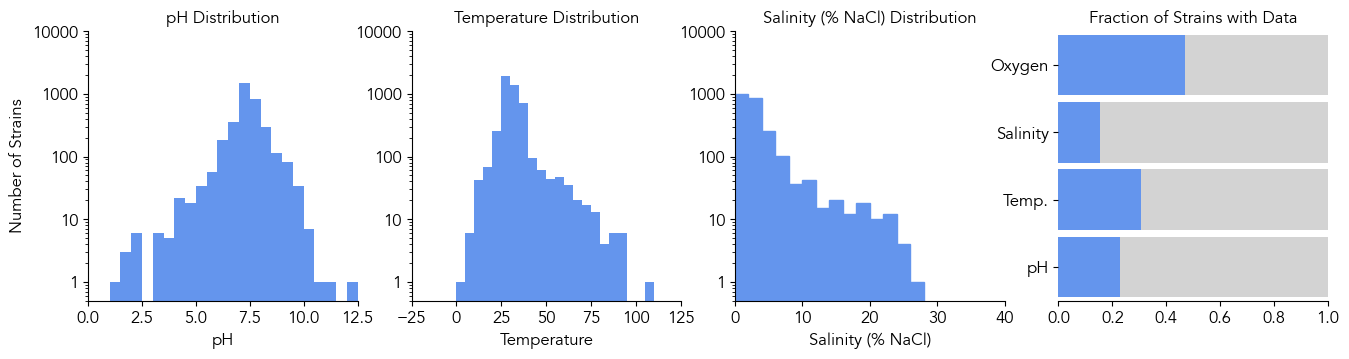

In [36]:
from matplotlib.ticker import FormatStrFormatter


fig , axes = plt.subplots(1,4,figsize=(16,3.5))

color = 'cornflowerblue'

var = 'ph_optimum'
bins = np.arange(0,13,0.5)
ax = axes[0]
ax.set_title('pH Distribution')
ax.set_xlabel('pH')
#ax.set_title('pH', y=1.0, pad=-2)
X = df[var].dropna().values
ax.hist(X, bins=bins, color=color)
ax.set_xlim([min(bins), max(bins)])
ax.set_ylabel('Number of Strains')

var = 'temperature_optimum'
bins = np.arange(-10,115,5)
ax = axes[1]
ax.set_title('Temperature Distribution')
ax.set_xlabel('Temperature')
#ax.set_title('Temperature', y=1.0, pad=-2)
X = df[var].dropna().values
ax.hist(X, bins=bins, color=color)
ax.set_xlim([min(bins), max(bins)])

var = 'salinity_optimum'
bins = np.arange(0,40,2)
ax = axes[2]
ax.set_title('Salinity (% NaCl) Distribution')
#ax.set_title('Salinity (% NaCl)', y=1.0, pad=-2)
X = df[var].dropna().values
ax.hist(X, bins=bins, color=color, edgecolor=color)
ax.set_xlim([min(bins), max(bins)])
ax.set_xlabel('Salinity (% NaCl)')


for ax in axes[0:3]:
    #ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.set_yticks(ax.get_yticks())
    ax.set_xticks(ax.get_xticks())
    #ax.set_ylabel('Strains')#, rotation=90, ha='right')

    ax.set_yscale('log')
    ax.set_ylim([5e-1, 1e4])
    ax.set_yticks([1, 10, 100, 1000, 10000])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for ax in axes:
    
    
    ax.tick_params(axis="y",direction="out")
    ax.tick_params(axis="x",direction="out")
    
ax = axes[3]
ax.spines['left'].set_visible(False)
bar_data = {}
for var, name in [('ph_optimum', 'pH'), ('temperature_optimum', 'Temp.'), ('salinity_optimum', 'Salinity'),  ('oxygen', 'Oxygen')]:
    nonnull = (~df[var].isnull()).sum()
    null = (df[var].isnull()).sum()
    bar_data[name] = {'Reported' : (nonnull / (null + nonnull)), 'Not Reported' : (null / (null + nonnull))}
pd.DataFrame(bar_data).T.plot.barh(ax=ax, stacked=True, color=[color, 'lightgray'], legend=False, width=0.9)
#ax.legend(bbox_to_anchor=(0,0), frameon=False)
ax.set_title('Fraction of Strains with Data')
ax.set_xlim([0,1])
ax.set_ylabel('')
ax.set_ylim([-0.5, 3.5])
# for y in range(0, 3, 1):
#     ax.text(0.03, y-0.1, '+')
#     ax.text(0.95, y-0.1, '-')
#plt.savefig('figures/histograms-physicochemistry.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for n, c in enumerate(['temperature', 'salinity', 'ph']):
#c = 'temperature'
    ax = axes[n]
    filter = (df[f'use_{c}_range'] == True) & (df[f'use_{c}_optimum'] == True) 
    
    x = f'{c}_optimum' 
    for suffix in '_max', '_min':
        y = c + suffix
        Y = df[filter][y].values
        X = df[filter][x].values
        
        ax.scatter(X,Y,s=5, label=y, alpha=1)
    ax.legend()
    
    ax.set_xlabel(x)

    ax.set_ylabel(c)